# LSTM from scratch

This notebook explains and implements a LSTM neural network from scratch in `Python`, using only `numpy`.

## Activation Functions
`Activation function` of a node in an artificial neural network is a function that calculates the output of the node (based on its inputs and the weights on individual inputs).

### Reason for non-linearity
Intuitively, activation functions introduce a non-linear component to neural networks, which makes them able to learn more than linear relationships between the dependent and independent variables. Without activation functions, the neural network could be simplified to a linear regression model, and suffer from the same limitations.

To understand it better, let's consider an example.

$$y = \Omega(\Omega(XW_1)W_2)$$

Here, $\Omega$ is the activation function, $X$ is the input, $W_1$ and $W_2$ are the weights (for the sake of simplicity we are ignoring the bias). If $\Omega$ is a linear function, then the whole expression can be simplified to:

$$y = X(W_1W_2)$$

This is a linear regression model, and can only learn linear relationships between the dependent and independent variables. However, if $\Omega$ is a non-linear function, then the whole expression cannot be simplified. This allows the neural network to learn non-linear relationships between the dependent and independent variables.



### Activation Functions for the LSTM

In [314]:
import numpy as np

def sigmoid(x: np.ndarray, derivative = False):
    """
    A sigmoid function is any mathematical function having a 
    characteristic S-shaped curve or sigmoid curve.
    
    Here we use the logistic function as the sigmoid function.
    The function takes any real value as input and outputs values in the range 0 to 1.
    
    ref.
    https://en.wikipedia.org/wiki/Sigmoid_function
    https://en.wikipedia.org/wiki/Logistic_function
    """
    if derivative:
        """
        Note that the derivative of the logistic function is given by f(x) * (1 - f(x)).
        However, this is wrong on purpose, because this function will only be applied to the output of the logistic function.
        So the input x will always be f(x) and not x.
        """
        return x * (1 - x)
    
    return 1 / (1 + np.exp(-x))


def tanh(x: np.ndarray, derivative = False):
    """
    The hyperbolic tangent activation function is also referred to simply as the Tanh (also “tanh” and “TanH“) function.
    It is very similar to the sigmoid activation function and even has the same S-shape.
    The function takes any real value as input and outputs values in the range -1 to 1.
    
    tanh(x) = sinh(x)/cosh(x) = (e^x - e^-x)/(e^x + e^-x)
    
    ref. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning
    """
    if derivative:
        """
        Note that the derivative of the tanh function is given by 1 - tanh(x)^2.
        However, this is wrong on purpose, because this function will only be applied to the output of the tanh function.
        So the input x will always be tanh(x) and not x.
        """
        return 1 - x ** 2
    
    return np.tanh(x)

def softmax(x: np.ndarray):
    """
    The softmax function, also known as softargmax or normalized exponential function, 
    converts a vector of K real numbers into a probability distribution of K possible outcomes. 
    It is a generalization of the logistic function to multiple dimensions, and used in multinomial logistic regression. 
    The softmax function is often used as the last activation function of a neural network to normalize the output 
    of a network to a probability distribution over predicted output classes.
    
    ref. https://en.wikipedia.org/wiki/Softmax_function
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## Initialization
Initialization is a crucial part of machine learning, deep learning, and neural networks.

### Why do we need to initialize?
The weights and biases of a neural network are initialized randomly, and then updated during the training process. The initial values of the weights and biases are very important, as they can affect the training process and the performance of the model. If the weights and biases are initialized poorly, then the training process can be very slow, and the model may not be able to learn the relationship between the dependent and independent variables. This is called the `vanishing gradient problem`.

### How do we initialize?
There are many ways to initialize the weights and biases of a neural network. The most common way is to initialize them randomly from a normal distribution with mean 0 and standard deviation 1. This is called `Xavier initialization`.


In [315]:
def init_weights(input_size: int, output_size: int):
    """
    The Xavier initialization (or Glorot initialization) is a popular technique for initializing weights 
    in a neural network. It’s named after the deep learning researcher Xavier Glorot.
    
    The main idea is to set the initial weights of the network in a way that allows the activations 
    and gradients to flow effectively during both forward and backpropagation. It considers the number 
    of input and output units of each layer to determine the scale of the random initialization.
    
    The uniform Xavier initialization states we should draw each weight w from a random uniform distribution 
    in the range from minus x to x, where x is equal to the square root of 6, divided by the number of inputs, 
    plus the number of outputs for the transformation
    
    ref. https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization
    """
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))


TODO: Document LSTM

In [316]:
from tqdm import tqdm


class LSTM:
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_epochs: int, learning_rate: float):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = init_weights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = init_weights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = init_weights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = init_weights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = init_weights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))
        
    def reset(self):
        self.concat_inputs = {}

        # Initiating -1th hidden state and cell state, to be used in the first time step
        self.hidden_states = {-1: np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1: np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}
        
    def forward(self, inputs: np.ndarray):
        self.reset()

        predictions = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            predictions += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return predictions
    
    def backward(self, errors: np.ndarray, inputs: dict[float, np.ndarray]):
        d_wf = np.zeros_like(self.wf) 
        d_bf = np.zeros_like(self.bf)
        d_wi = np.zeros_like(self.wi)
        d_bi = np.zeros_like(self.bi)
        d_wc = np.zeros_like(self.wc)
        d_bc = np.zeros_like(self.bc)
        d_wo = np.zeros_like(self.wo)
        d_bo = np.zeros_like(self.bo)
        d_wy = np.zeros_like(self.wy)
        d_by = np.zeros_like(self.by)

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i
            
            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out=d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate
        
    def train(self, inputs: np.ndarray, labels: np.ndarray):
        for _ in tqdm(range(self.num_epochs)):
            predictions = self.forward(inputs)

            errors = []
            for q in range(len(predictions)):                
                errors += [-softmax(predictions[q])]
             
            self.backward(np.array(errors), self.concat_inputs)
    
    def test(self, inputs: np.ndarray, labels: np.ndarray):
        accuracy = 0
        predictions = self.forward(inputs)

        output = []
        for q in range(len(labels)):
            # Apply softmax to convert logits to probabilities
            softmax_output = softmax(predictions[q])

            # Get the index of the max probability as the prediction
            best_prediction_index = np.argmax(softmax_output)
            prediction = predictions[q][best_prediction_index]
            
            output.append(str(prediction))

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\n{labels}\n')
        print(f'Predictions:\n{"; ".join(output)}\n')
        
        print(f'Accuracy: {round(accuracy * 100 / len(inputs), 2)}%')

## Input Data
The input data is the historical prices of IBOVESPA(Brazilian stock market index) from Apr 26, 1993 to Jan 08, 2024.
The data is downloaded from [Yahoo Finance](https://finance.yahoo.com/quote/%5EBVSP/history/)



In [317]:
import pandas as pd

df = pd.read_csv('^BVSP.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0.0
1,1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0.0
2,1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0.0
3,1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0.0
4,1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0.0
...,...,...,...,...,...,...,...
7771,2024-01-02,134186.000000,134195.000000,132095.000000,132697.000000,132697.000000,8437800.0
7772,2024-01-03,132697.000000,133576.000000,132250.000000,132834.000000,132834.000000,8702400.0
7773,2024-01-04,132831.000000,132885.000000,131024.000000,131226.000000,131226.000000,8972300.0
7774,2024-01-05,131218.000000,132635.000000,130579.000000,132023.000000,132023.000000,9199700.0


Some days are missing from the data, so we need to fill in the missing values. 

We will use the values from the previous day.


In [318]:

missing_values = df[df['Close'].isna()] 
display(missing_values)

for i in range(len(missing_values)):   
    index = missing_values.index[i]
    df.at[index, 'Open'] = df.at[index - 1, 'Open']
    df.at[index, 'High'] = df.at[index - 1, 'High'] 
    df.at[index, 'Low'] = df.at[index - 1, 'Low']
    df.at[index, 'Close'] = df.at[index - 1, 'Close']
    df.at[index, 'Adj Close'] = df.at[index - 1, 'Adj Close']
    df.at[index, 'Volume'] = df.at[index - 1, 'Volume']
  
display(df[df['Close'].isna()])  
df


,Date,Open,High,Low,Close,Adj Close,Volume
32,1993-06-10,NaN,NaN,NaN,NaN,NaN,NaN
95,1993-09-07,NaN,NaN,NaN,NaN,NaN,NaN
120,1993-10-12,NaN,NaN,NaN,NaN,NaN,NaN
135,1993-11-02,NaN,NaN,NaN,NaN,NaN,NaN
144,1993-11-15,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6242,2017-11-02,NaN,NaN,NaN,NaN,NaN,NaN
6251,2017-11-15,NaN,NaN,NaN,NaN,NaN,NaN
6254,2017-11-20,NaN,NaN,NaN,NaN,NaN,NaN
6279,2017-12-25,NaN,NaN,NaN,NaN,NaN,NaN


,Date,Open,High,Low,Close,Adj Close,Volume


,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0.0
1,1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0.0
2,1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0.0
3,1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0.0
4,1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0.0
...,...,...,...,...,...,...,...
7771,2024-01-02,134186.000000,134195.000000,132095.000000,132697.000000,132697.000000,8437800.0
7772,2024-01-03,132697.000000,133576.000000,132250.000000,132834.000000,132834.000000,8702400.0
7773,2024-01-04,132831.000000,132885.000000,131024.000000,131226.000000,131226.000000,8972300.0
7774,2024-01-05,131218.000000,132635.000000,130579.000000,132023.000000,132023.000000,9199700.0


## Training and Testing
The data is split into training and testing sets. The training set is used to train the model, and the testing set is used to evaluate the performance of the model.

For the training set, the first 80% of the data is used. For the testing set, the last 20% of the data is used.

`We want to predict the 'Close' price of the next day, given the 'Close' price of the previous days.`

In [319]:
df= df[['Close']]

df

,Close
0,24.500000
1,24.299999
2,23.700001
3,24.100000
4,24.100000
...,...
7771,132697.000000
7772,132834.000000
7773,131226.000000
7774,132023.000000


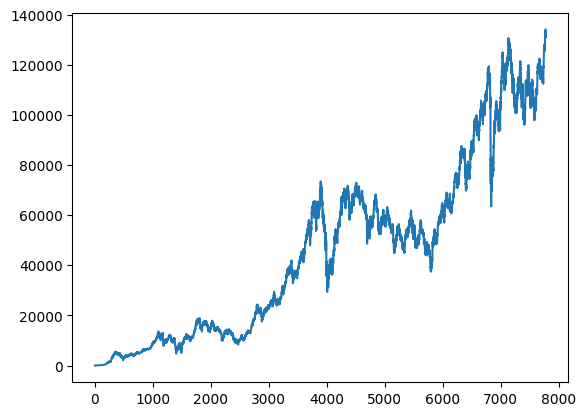

In [320]:
import matplotlib.pyplot as plt

plt.plot(df)

In [321]:
from sklearn import preprocessing 

train_size = int(len(df) * 0.8)

# Split Data

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Scale Data
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def normalize_input(data, input_size):
    x, y = [], []
    for i in range(len(data) - input_size):
        x.append(data[i:i + input_size])
        y.append(data[i + input_size])
    return np.array(x), np.array(y)

input_size = 5
train_x, train_y = normalize_input(train_scaled, input_size)
test_x, test_y = normalize_input(test_scaled, input_size)


# Initialize Network

# How deep should the network be?
hidden_size = 25

lstm = LSTM(input_size = input_size + hidden_size, hidden_size = hidden_size, output_size = input_size, num_epochs = 1_000, learning_rate = 0.05)

# Training
lstm.train(train_x, train_y)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [10:23<00:00,  1.60it/s]


In [322]:
# Testing
lstm.test(test_x, test_y)

Ground Truth:
[[1.01175305]
 [1.00863382]
 [1.00863382]
 ...
 [1.72679366]
 [1.73728322]
 [1.74260038]]

Predictions:
[-1001.41515836]; [-1255.12807812]; [-1294.0326411]; [-1299.39394407]; [-1300.12146784]; [-1300.21999082]; [-1300.23333021]; [-1300.23513635]; [-1300.23538092]; [-1300.23541404]; [-1300.23541852]; [-1300.23541913]; [-1300.23541921]; [-1300.23541922]; [-1300.23541922]; [-1300.23541922]; [-1300.23541922]; [-1300.23541922]; [-1300.23541922]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.2354192]; [-1300.2354192]; [-1300.2354192]; [-1300.2354192]; [-1300.2354192]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.2354192]; [-1300.2354192]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.23541921]; [-1300.2

References:
- https://medium.com/mlearning-ai/building-a-neural-network-zoo-from-scratch-the-long-short-term-memory-network-1cec5cf31b7
- https://medium.com/@shouke.wei/practical-process-to-develop-a-simple-lstm-time-series-prediction-model-30910de3b99#4503